In [1]:
import uproot
import glob
import numpy as np
import math
import torch
import torch_geometric
import random
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GraphSAGE
from torch.nn import BCELoss, BCEWithLogitsLoss, L1Loss
import torch.nn.functional as func
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, f1_score

import Models
import MPNN

In [2]:
#############################
# Some config
#############################
BATCH_SIZE = 64 #128
TRAIN_FRACTION = 0.8
N_EPOCH = 40
NUM_NODE_CLASSES = 5

USE_L1_REG = False
LAMBDA_FACTOR = 0.00005
USE_L2_REG = False # Would have to use a different optimiser e.g. optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.003)

In [3]:
#############################
# Read from file
#############################

fileIndices = ['0', '1']

# Define data set
data_set_pos = []
data_set_neg = []
data_set_FC = []

fileDir = '/Users/isobel/Desktop/DUNE/2024/Hierarchy/'

for fileIndex in fileIndices :

    # Get file 
    outputFileSuffix = '_ParticleToNeutrinoTruth_EdgeAttr_SWAP'
    posFilePath = fileDir + 'data_set_pos'+ outputFileSuffix + '_' + fileIndex + '.pt'
    negFilePath = fileDir + 'data_set_neg'+ outputFileSuffix + '_' + fileIndex + '.pt'
    fcFilePath = fileDir + 'data_set_FC'+ outputFileSuffix + '_' + fileIndex + '.pt'
      
    fileData_pos = torch.load(posFilePath)
    fileData_neg = torch.load(negFilePath)
    fileData_FC = torch.load(fcFilePath)
    
    data_set_pos += fileData_pos
    data_set_neg += fileData_neg
    data_set_FC += fileData_FC

In [4]:
print('================================================================================')
graphIndex = 0
print('We are working with:', len(data_set_FC), 'graphs.')
print('Let\'s look at the', graphIndex, 'index graph...')
print('================================================================================')

print(f'Number of nodes: {data_set_FC[graphIndex].num_nodes}')
print(f'Number of edges: {data_set_FC[graphIndex].num_edges}')
print(data_set_FC[graphIndex].edge_index)
print(f'Has isolated nodes: {data_set_FC[graphIndex].has_isolated_nodes()}')
print(f'Has self-loops: {data_set_FC[graphIndex].has_self_loops()}')
#print(f'Is undirected: {data_set_FC[graphIndex].is_undirected()}')

print(f'Edge weights: {data_set_FC[graphIndex].edge_weight}')

#G = to_networkx(data_set[graphIndex], to_undirected=True)
#visualize_graph(G, color=data_set[graphIndex].y)

We are working with: 164990 graphs.
Let's look at the 0 index graph...
Number of nodes: 9
Number of edges: 52
tensor([[0, 1, 2, 3, 4, 5, 6, 7, 6, 4, 4, 1, 2, 0, 4, 0, 1, 0, 2, 1, 5, 3, 3, 2,
         6, 0, 6, 1, 3, 1, 7, 5, 7, 3, 4, 2, 7, 6, 5, 2, 7, 1, 3, 0, 6, 2, 7, 4,
         4, 3, 5, 1],
        [8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 1, 4, 0, 2, 0, 4, 0, 1, 1, 2, 3, 5, 2, 3,
         0, 6, 1, 6, 1, 3, 5, 7, 3, 7, 2, 4, 6, 7, 2, 5, 1, 7, 0, 3, 2, 6, 4, 7,
         3, 4, 1, 5]])
Has isolated nodes: False
Has self-loops: False
Edge weights: None


In [5]:
###########################################
# Create training/testing nodes
###########################################

train_size = int(len(data_set_FC) * TRAIN_FRACTION)

data_set_train_neg = data_set_neg[:train_size]
data_set_test_neg = data_set_neg[train_size:]

data_set_train_pos = data_set_pos[:train_size]
data_set_test_pos = data_set_pos[train_size:]

data_set_train_FC = data_set_FC[:train_size]
data_set_test_FC = data_set_FC[train_size:]

print('================================================================================')
print('Fully Connected')
print('Number of training graphs:', len(data_set_train_FC))
print('Number of test graphs:', len(data_set_test_FC))
print('================================================================================')
print('Positive')
print('Number of training graphs:', len(data_set_train_pos))
print('Number of test graphs:', len(data_set_test_pos))
print('================================================================================')
print('Negative')
print('Number of training graphs:', len(data_set_train_neg))
print('Number of test graphs:', len(data_set_test_neg))
print('================================================================================')

Fully Connected
Number of training graphs: 131992
Number of test graphs: 32998
Positive
Number of training graphs: 131992
Number of test graphs: 32998
Negative
Number of training graphs: 131992
Number of test graphs: 32998


In [6]:
###########################################
# Let's create batches
###########################################

# Do this to ensure common shuffling

class MyDataset(Dataset):
    def __init__(self, pos_dataset, neg_dataset, FC_dataset):
        self.pos_dataset = pos_dataset
        self.neg_dataset = neg_dataset
        self.FC_dataset = FC_dataset
        
    def __getitem__(self, index):
        xA = self.pos_dataset[index]
        xB = self.neg_dataset[index]
        xFC = self.FC_dataset[index]
        return xA, xB, xFC
    
    def __len__(self):
        return len(self.pos_dataset)
    
train_dataset = MyDataset(data_set_train_pos, data_set_train_neg, data_set_train_FC)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = MyDataset(data_set_test_pos, data_set_test_neg, data_set_test_FC)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
data_pos, data_neg, data_FC = train_dataset[0]

# Work out primaries/others - I've hidden this in the graph truth (edge_attr) info
primary_pos_edge_mask = data_pos.edge_attr.reshape(-1)
primary_neg_edge_mask = data_neg.edge_attr.reshape(-1)
other_pos_edge_mask = torch.logical_not(primary_pos_edge_mask)
other_neg_edge_mask = torch.logical_not(primary_neg_edge_mask)

In [8]:
###########################################
# Calculate pos/neg training edge weight
###########################################

# Edges
n_pos_edges_train = 0
n_neg_edges_train = 0

# Nodes
n_class_zero = 0
n_class_one = 0
n_class_two = 0
n_class_three = 0
n_class_four = 0

for data_pos, data_neg, data_FC in train_dataloader :
    #############
    # Edges
    #############
    n_pos_edges_train += data_pos.num_edges
    n_neg_edges_train += data_neg.num_edges
#     #############
#     # Nodes
#     #############
#     class_tensor = torch.argmax(data_FC.y, axis=1)
#     n_class_zero += torch.count_nonzero(class_tensor == 0).item()
#     n_class_one += torch.count_nonzero(class_tensor == 1).item()
#     n_class_two += torch.count_nonzero(class_tensor == 2).item()
#     n_class_three += torch.count_nonzero(class_tensor == 3).item()
#     n_class_four += torch.count_nonzero(class_tensor == 4).item()


#############
# Edges
#############
total_edges_train = n_pos_edges_train + n_neg_edges_train
pos_edge_weight_train = total_edges_train / (n_pos_edges_train * 2)
neg_edge_weight_train = total_edges_train / (n_neg_edges_train * 2)

print('---')
print('n_pos_edges_train:', n_pos_edges_train)
print('n_neg_edges_train:', n_neg_edges_train)

print('pos_edge_weight_train:', pos_edge_weight_train)
print('neg_edge_weight_train:', neg_edge_weight_train)
print('---')

#############
# Nodes
#############
# print('n_class_zero:', n_class_zero)
# print('n_class_one:', n_class_one)
# print('n_class_two:', n_class_two)
# print('n_class_three:', n_class_three)
# print('n_class_four:', n_class_four)

# max_node_category = max(n_class_zero, n_class_one, n_class_two, n_class_three, n_class_four)
# class_zero_weight = float(max_node_category) / n_class_zero
# class_one_weight = float(max_node_category) / n_class_one
# class_two_weight = float(max_node_category) / n_class_two
# class_three_weight = float(max_node_category) / n_class_three
# class_four_weight = float(max_node_category) / n_class_four

# node_weight_sum = class_zero_weight + class_one_weight + class_two_weight + class_three_weight + class_four_weight
# class_zero_weight /= node_weight_sum
# class_one_weight /= node_weight_sum 
# class_two_weight /= node_weight_sum 
# class_three_weight /= node_weight_sum 
# class_four_weight /= node_weight_sum 

# print('class_zero_weight:', class_zero_weight)
# print('class_one_weight:', class_one_weight)
# print('class_two_weight:', class_two_weight)
# print('class_three_weight:', class_three_weight)
# print('class_four_weight:', class_four_weight)

# class_weights = [class_zero_weight, class_one_weight, class_two_weight, class_three_weight, class_four_weight]

---
n_pos_edges_train: 728310
n_neg_edges_train: 132330
pos_edge_weight_train: 0.5908473040326234
neg_edge_weight_train: 3.251870324189526
---


In [9]:
#######################################
# Create our model
#######################################

N_NODE_FEATURES = data_set_FC[0].num_features
HIDDEN_CHANNELS = 16 #64 #16
NUM_LAYERS = 2
NUM_EDGE_ATTR=5


#USE_GRAPHSAGE = True

#if (USE_GRAPHSAGE) :
    #gnn_model = GraphSAGE(N_NODE_FEATURES, hidden_channels=HIDDEN_CHANNELS, num_layers=NUM_LAYERS)
#else :
    #gnn_model = Models.GNN(N_NODE_FEATURES, HIDDEN_CHANNELS)
        
    
gnn_model = MPNN.MPNNModel(num_layers=4, emb_dim=HIDDEN_CHANNELS, input_dim=N_NODE_FEATURES, edge_dim=NUM_EDGE_ATTR)
edge_classifier_model = Models.EdgeClassifier()
node_classifier_model = Models.NodeClassifier(HIDDEN_CHANNELS, NUM_NODE_CLASSES)

In [10]:
print(N_NODE_FEATURES)

14


In [11]:
#######################################
# Move model to device 
#######################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
gnn_model = gnn_model.to(device)
edge_classifier_model = edge_classifier_model.to(device)
node_classifier_model = node_classifier_model.to(device)

Device: 'cpu'


In [12]:
#######################################
# Define some training functions
#######################################

def ComputeLoss(pos_score, neg_score, pos_edge_weight, neg_edge_weight):
    
    scores = torch.cat([pos_score, neg_score]).reshape(-1, 1)
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).reshape(-1, 1)
    weight = torch.tensor([neg_score.shape[0] / pos_score.shape[0]], dtype=torch.float)
    
    loss_function = BCEWithLogitsLoss(pos_weight=weight)
    
    return loss_function(scores, labels)
    
    #return func.binary_cross_entropy(scores, labels, weight=weight)


def ComputeF1Score(pos_score, neg_score):
    
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    
    # Have to apply some threshold to get the F1 score
    scores[scores > 0.5] = 1
    scores[scores < 0.5] = 0
    
    print(scores)
    
    #positive_weight = torch.ones(pos_score.shape[0]) * pos_edge_weight
    #negative_weight = torch.ones(neg_score.shape[0]) * neg_edge_weight
    #weight = torch.cat([positive_weight, negative_weight])
    return f1_score(labels, scores)


def plot_scores(pos_test_score, neg_test_score, train_or_test):
    
    pos_plotting_weights = 1.0 / float(len(pos_test_score))
    pos_plotting_weights = np.ones(len(pos_test_score)) * pos_plotting_weights
    neg_plotting_weights = 1.0 / float(len(neg_test_score))
    neg_plotting_weights = np.ones(len(neg_test_score)) * neg_plotting_weights
    
    plt.hist(pos_test_score, bins=50, range=(0, 1.1), alpha=0.3, color='blue', edgecolor='black', label='pos_test_score', weights=pos_plotting_weights)
    plt.hist(neg_test_score, bins=50, range=(0, 1.1), alpha=0.3, color='red', edgecolor='black', label='neg_test_score', weights=neg_plotting_weights)

    #plt.yscale('log')
    plt.title(train_or_test)
    plt.legend()
    plt.show()    
    
def plot_loss_evolution(epochs, training_loss, test_loss, accuracy, ylim1, ylim2):
    fig, ax1 = plt.subplots()

    ax1.plot(epochs, training_loss, label='Training Loss', color='b')
    ax1.plot(epochs, test_loss, label='Validation Loss', color='g')

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper left')
    ax1.set_title('Training and Validation Loss Over Epochs')

    ax2 = ax1.twinx()
    ax2.plot(epochs, accuracy, label='Accuracy', color='r')
    ax2.set_ylabel('Accuracy Scale', color='r')
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper right')

    if ylim1 > 0:
        ax1.set_ylim(0.0001, ylim1)
    if ylim2 > 0:
        ax2.set_ylim(0.0001, ylim2)
    ax1.set_yscale('log')

    plt.draw()
    plt.show()
        
    
def calculate_accuracy(pos_test_score, neg_test_score):
    scores = torch.cat([pos_test_score, neg_test_score])
    true_labels = torch.cat([torch.ones(pos_test_score.shape[0]), torch.zeros(neg_test_score.shape[0])]).numpy()

    thresholds = torch.arange(0.05, 1.0, 0.05)
    predictions = []
    accuracy = []

    for threshold in thresholds:
        prediction = (scores >= threshold).float()
        accuracy.append(accuracy_score(true_labels, prediction.numpy()))
        predictions.append(prediction)

    max_accuracy = torch.max(torch.tensor(accuracy))
    max_accuracy_index = torch.argmax(torch.tensor(accuracy))
    optimal_threshold = thresholds[max_accuracy_index].item()

    return optimal_threshold, max_accuracy

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
----------------------------------------
Epoch: 5
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.77%
positive_as_positive_fraction_train: 75.58%
positive_as_negative_fraction_train: 24.42%
negative_as_negative_fraction_train: 83.23%
negative_as_positive_fraction_train: 16.77%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.75%
positive_as_positive_fraction_test: 73.0%
positive_as_negative_fraction_test: 27.0%
negative_as_negative_fraction_test: 82.83%
negative_as_positive_fraction_test: 17.17%
----


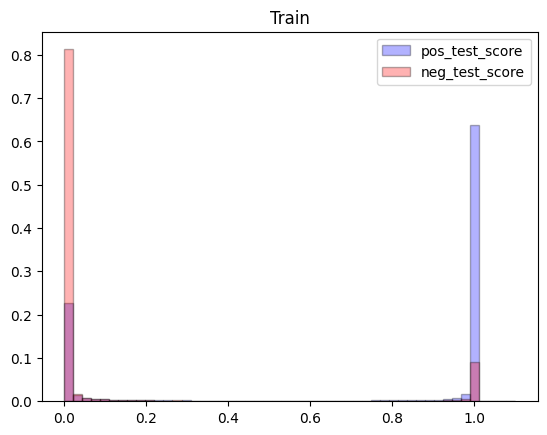

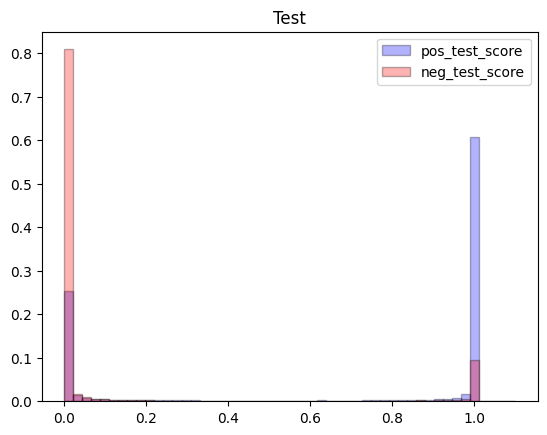

Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
----------------------------------------
Epoch: 10
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.8%
positive_as_positive_fraction_train: 78.88%
positive_as_negative_fraction_train: 21.12%
negative_as_negative_fraction_train: 84.39%
negative_as_positive_fraction_train: 15.61%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.77%
positive_as_positive_fraction_test: 75.78%
positive_as_negative_fraction_test: 24.22%
negative_as_negative_fraction_test: 84.39%
negative_as_positive_fraction_test: 15.61%
----


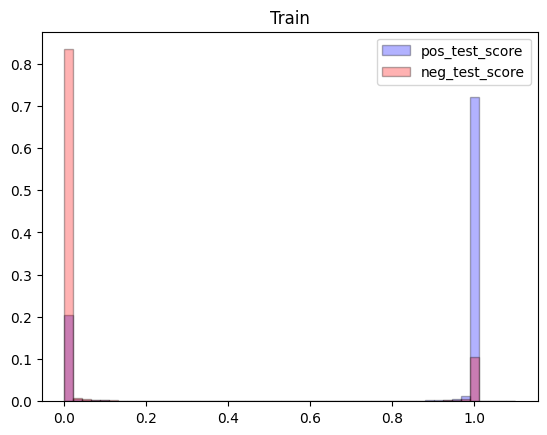

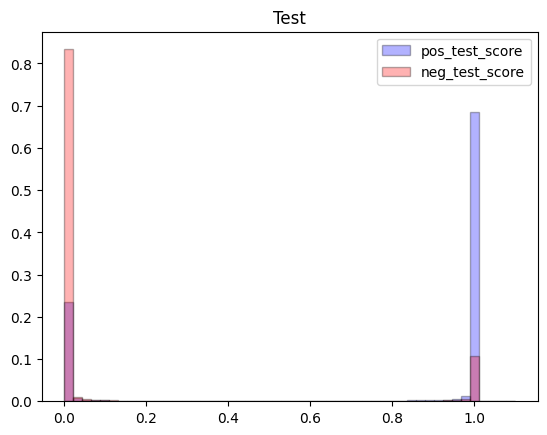

Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
----------------------------------------
Epoch: 15
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.79%
positive_as_positive_fraction_train: 78.02%
positive_as_negative_fraction_train: 21.98%
negative_as_negative_fraction_train: 86.01%
negative_as_positive_fraction_train: 13.99%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.77%
positive_as_positive_fraction_test: 74.95%
positive_as_negative_fraction_test: 25.05%
negative_as_negative_fraction_test: 86.02%
negative_as_positive_fraction_test: 13.98%
----


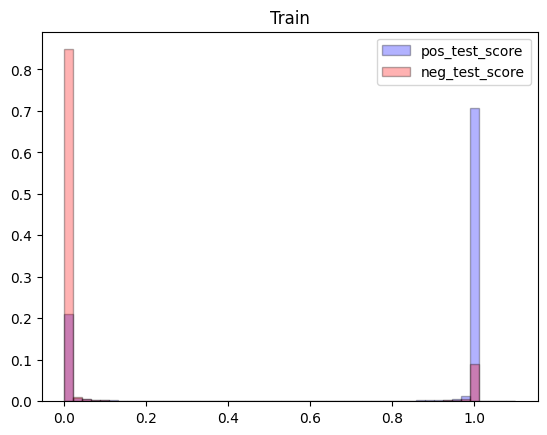

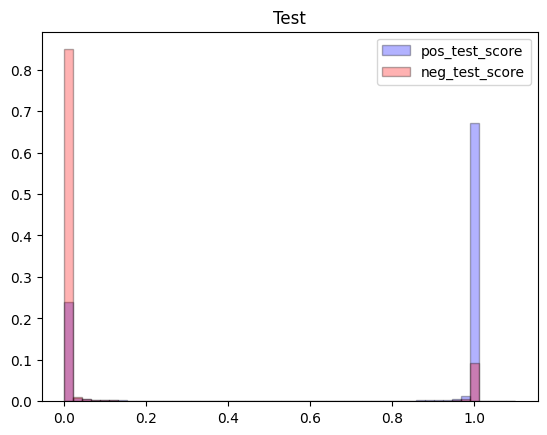

Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
----------------------------------------
Epoch: 20
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.82%
positive_as_positive_fraction_train: 81.67%
positive_as_negative_fraction_train: 18.33%
negative_as_negative_fraction_train: 84.07%
negative_as_positive_fraction_train: 15.93%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.8%
positive_as_positive_fraction_test: 78.48%
positive_as_negative_fraction_test: 21.52%
negative_as_negative_fraction_test: 84.41%
negative_as_positive_fraction_test: 15.59%
----


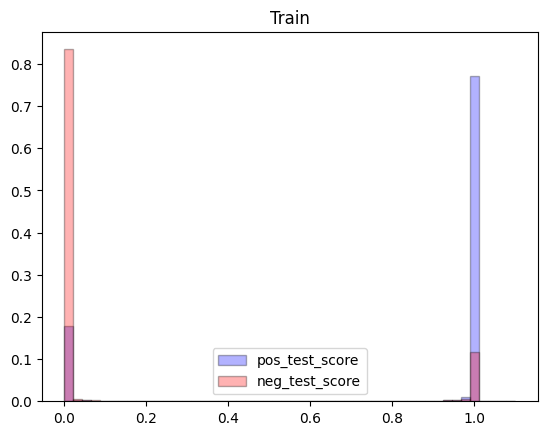

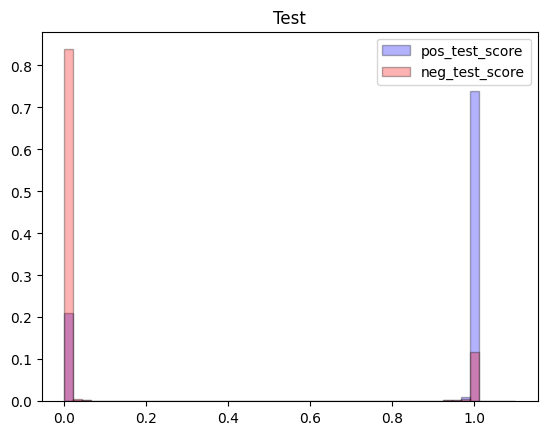

Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
----------------------------------------
Epoch: 25
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.78%
positive_as_positive_fraction_train: 76.54%
positive_as_negative_fraction_train: 23.46%
negative_as_negative_fraction_train: 88.82%
negative_as_positive_fraction_train: 11.18%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.76%
positive_as_positive_fraction_test: 73.55%
positive_as_negative_fraction_test: 26.45%
negative_as_negative_fraction_test: 88.81%
negative_as_positive_fraction_test: 11.19%
----


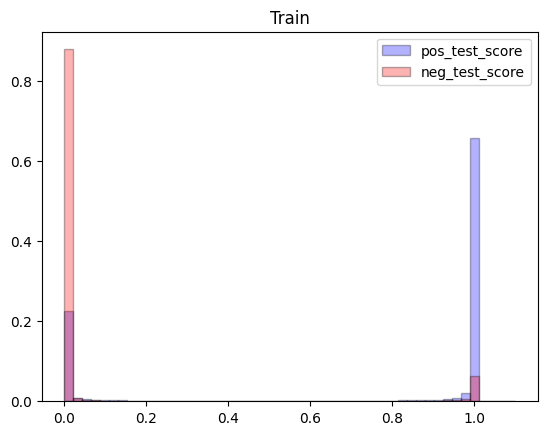

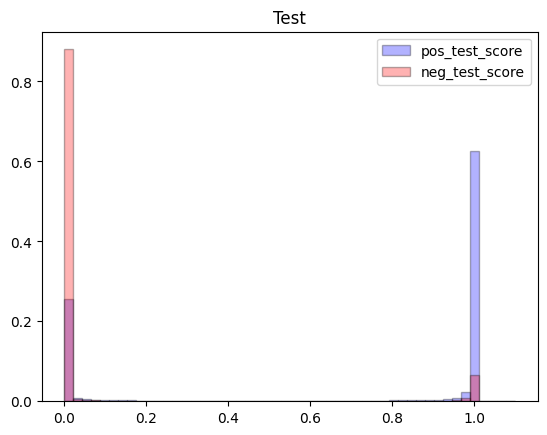

Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
----------------------------------------
Epoch: 30
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.81%
positive_as_positive_fraction_train: 79.25%
positive_as_negative_fraction_train: 20.75%
negative_as_negative_fraction_train: 88.14%
negative_as_positive_fraction_train: 11.86%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.78%
positive_as_positive_fraction_test: 75.82%
positive_as_negative_fraction_test: 24.18%
negative_as_negative_fraction_test: 88.25%
negative_as_positive_fraction_test: 11.75%
----


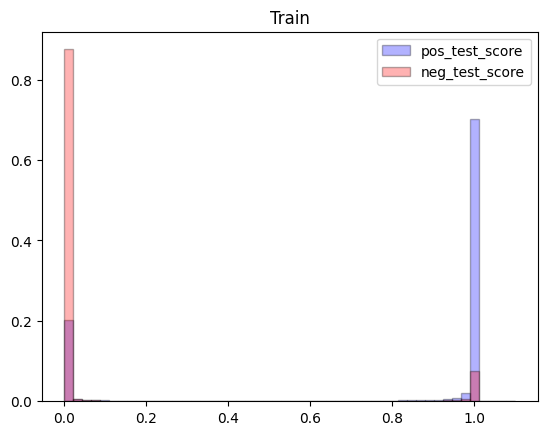

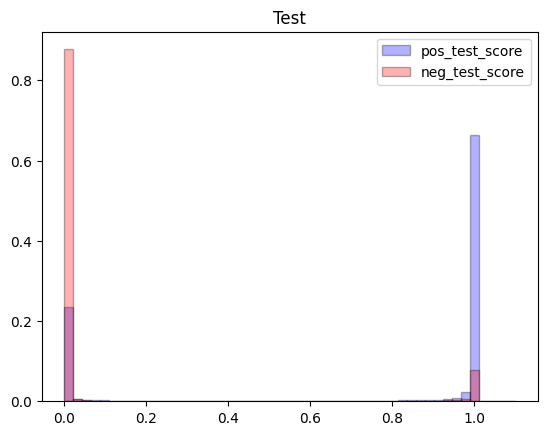

Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
----------------------------------------
Epoch: 35
----------------------------------------
loss_train: 0.18
----
optimal_threshold_train: 0.05000000074505806
accuracy_train: 0.83%
positive_as_positive_fraction_train: 83.12%
positive_as_negative_fraction_train: 16.88%
negative_as_negative_fraction_train: 84.2%
negative_as_positive_fraction_train: 15.8%
----
loss_test: 0.21
----
optimal_threshold_test: 0.05000000074505806
accuracy_test: 0.81%
positive_as_positive_fraction_test: 79.84%
positive_as_negative_fraction_test: 20.16%
negative_as_negative_fraction_test: 84.94%
negative_as_positive_fraction_test: 15.06%
----


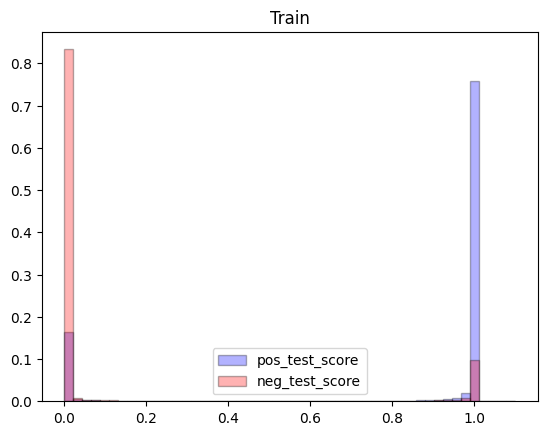

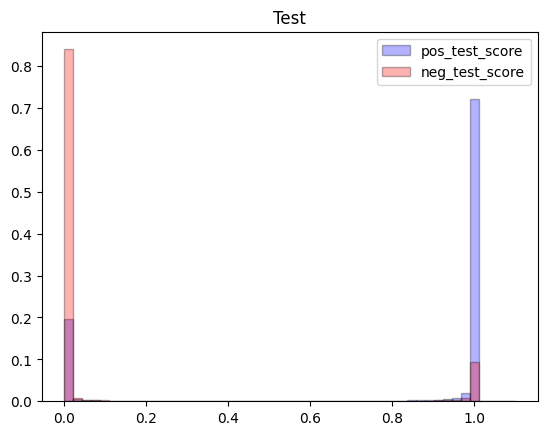

Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39


In [13]:
#######################################
# Do training
#######################################

SAMPLE_INTERVAL = 5

# Optimiser
optimiser = torch.optim.Adam(itertools.chain(gnn_model.parameters(), edge_classifier_model.parameters()), lr=1e-3)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

# Put here some metrics
training_loss = []
training_accuracy = []
training_positive_as_positive_rate = []
training_positive_as_negative_rate = []
training_negative_as_negative_rate = []
training_negative_as_positive_rate = []

test_loss = []
test_accuracy = []
test_positive_as_positive_rate = []
test_positive_as_negative_rate = []
test_negative_as_negative_rate = []
test_negative_as_positive_rate = []

for epoch in range(N_EPOCH):
    
    print('Epoch:', epoch)
    
    ######################
    # Training 
    ######################
    gnn_model.train()
    edge_classifier_model.train()
    
    # Iterate in batches over the training dataset.                        
    for data_pos, data_neg, data_FC in train_dataloader:  
        
        # Skip incomplete batches
        if (data_FC.num_graphs != BATCH_SIZE) :
            continue
    
        # Get node embeddings
        #pred = gnn_model(data_FC.x, data_FC.edge_index, edge_weight=data_FC.edge_weight)
        pred = gnn_model(data_FC)
             
        # Get edge predictions
        edge_pred_pos = edge_classifier_model(pred, data_pos.edge_index)
        edge_pred_neg = edge_classifier_model(pred, data_neg.edge_index)

        # Calculate loss
        loss = ComputeLoss(edge_pred_pos, edge_pred_neg, pos_edge_weight_train, neg_edge_weight_train)

        # L1 Regularisation
        if (USE_L1_REG):
      
            l1_crit = L1Loss(size_average=False)
            reg_loss = 0
            
            for param in gnn_model.parameters():
                reg_loss += l1_crit(param, target=torch.zeros_like(param))

            # Add other models?
    
            loss += LAMBDA_FACTOR * reg_loss
        
        # Update model parameters
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()  
        
    #before_lr = optimiser.param_groups[0]["lr"]
    #scheduler.step(loss)
    #scheduler.step(this_f1_score)
    #after_lr = optimiser.param_groups[0]["lr"]
    #print("Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr))
        
        
    if (epoch != 0) and (epoch % SAMPLE_INTERVAL == 0) :
        ######################
        # Testing - here i'm collecting metrics.
        ######################
    
        with torch.no_grad():
        
            # Begin testing mode
            gnn_model.eval()
            edge_classifier_model.eval()
                
            # Initialise metrics - need to look at training again...
            total_loss_train = 0
            total_batches_train = 0 
            pos_scores_train = []
            neg_scores_train = []
            pos_scores_train = []
            neg_scores_train = []
        
            # Iterate in batches over the training dataset.                        
            for data_pos, data_neg, data_FC in train_dataloader :
        
                # Skip incomplete batches
                if (data_FC.num_graphs != BATCH_SIZE) :
                    continue
            
                # Get node embeddings
                #pred = gnn_model(data_FC.x, data_FC.edge_index, edge_weight=data_FC.edge_weight)
                pred = gnn_model(data_FC)
             
                # Get edge predictions
                edge_pred_pos = edge_classifier_model(pred, data_pos.edge_index)
                edge_pred_neg = edge_classifier_model(pred, data_neg.edge_index)
            
                loss = ComputeLoss(edge_pred_pos, edge_pred_neg, pos_edge_weight_train, neg_edge_weight_train)
                
                # L1 Regularisation
                if (USE_L1_REG):
                    
                    l1_crit = L1Loss(size_average=False)
                    reg_loss = 0

                    for param in gnn_model.parameters():
                        reg_loss += l1_crit(param, target=torch.zeros_like(param))


                    loss += LAMBDA_FACTOR * reg_loss
                
                total_loss_train += loss.item()
                total_batches_train += 1

                # Add to metrics
                pos_scores_train.extend(edge_pred_pos)
                neg_scores_train.extend(edge_pred_neg)
            
            # Initialise metrics - now look at testing...
            total_loss_test = 0
            total_batches_test = 0 
            pos_scores_test = []
            neg_scores_test = []
        
            # Iterate in batches over the testing dataset
            for data_pos, data_neg, data_FC in test_dataloader :
            
                # Skip incomplete batches
                if (data_FC.num_graphs != BATCH_SIZE) :
                    continue
    
                # Get node embeddings
                #pred = gnn_model(data_FC.x, data_FC.edge_index, edge_weight=data_FC.edge_weight)
                pred = gnn_model(data_FC)
        
                # Get edge predictions
                edge_pred_pos = edge_classifier_model(pred, data_pos.edge_index)
                edge_pred_neg = edge_classifier_model(pred, data_neg.edge_index)
                                    
                # Calculate loss
                loss = ComputeLoss(edge_pred_pos, edge_pred_neg, pos_edge_weight_train, neg_edge_weight_train)
                
                # L1 Regularisation
                if (USE_L1_REG):
                    
                    l1_crit = L1Loss(size_average=False)
                    reg_loss = 0

                    for param in gnn_model.parameters():
                        reg_loss += l1_crit(param, target=torch.zeros_like(param))

                    loss += LAMBDA_FACTOR * reg_loss
                    
                total_loss_test += loss.item()
                total_batches_test += 1
            
                # Add to metrics
                pos_scores_test.extend(edge_pred_pos)
                neg_scores_test.extend(edge_pred_neg)
                            
        ######################
        # Metrics for epoch 
        ######################   
        # train
        optimal_threshold_train, maximum_accuracy_train = calculate_accuracy(torch.tensor(pos_scores_train), torch.tensor(neg_scores_train)) 
        # test
        optimal_threshold_test, maximum_accuracy_test = calculate_accuracy(torch.tensor(pos_scores_test), torch.tensor(neg_scores_test))
    
        # train
        positive_as_positive_train = np.count_nonzero(np.array(pos_scores_train) > optimal_threshold_train)
        positive_as_negative_train = np.count_nonzero(np.array(pos_scores_train) < optimal_threshold_train)
        negative_as_positive_train = np.count_nonzero(np.array(neg_scores_train) > optimal_threshold_train)
        negative_as_negative_train = np.count_nonzero(np.array(neg_scores_train) < optimal_threshold_train)
        # test
        positive_as_positive_test = np.count_nonzero(np.array(pos_scores_test) > optimal_threshold_test)
        positive_as_negative_test = np.count_nonzero(np.array(pos_scores_test) < optimal_threshold_test)
        negative_as_positive_test = np.count_nonzero(np.array(neg_scores_test) > optimal_threshold_test)
        negative_as_negative_test = np.count_nonzero(np.array(neg_scores_test) < optimal_threshold_test)
    
        # train
        positive_as_positive_fraction_train = float(positive_as_positive_train) / float(positive_as_positive_train + positive_as_negative_train)
        positive_as_negative_fraction_train = float(positive_as_negative_train) / float(positive_as_positive_train + positive_as_negative_train)
        negative_as_positive_fraction_train = float(negative_as_positive_train) / float(negative_as_positive_train + negative_as_negative_train)
        negative_as_negative_fraction_train = float(negative_as_negative_train) / float(negative_as_positive_train + negative_as_negative_train)
        # test
        positive_as_positive_fraction_test = float(positive_as_positive_test) / float(positive_as_positive_test + positive_as_negative_test)
        positive_as_negative_fraction_test = float(positive_as_negative_test) / float(positive_as_positive_test + positive_as_negative_test)
        negative_as_positive_fraction_test = float(negative_as_positive_test) / float(negative_as_positive_test + negative_as_negative_test)
        negative_as_negative_fraction_test = float(negative_as_negative_test) / float(negative_as_positive_test + negative_as_negative_test)
    
        # train
        training_loss.append(float(total_loss_train) / float(total_batches_train))
        training_accuracy.append(maximum_accuracy_train)
        training_positive_as_positive_rate.append(positive_as_positive_fraction_train)
        training_positive_as_negative_rate.append(positive_as_negative_fraction_train)
        training_negative_as_negative_rate.append(negative_as_negative_fraction_train)
        training_negative_as_positive_rate.append(negative_as_positive_fraction_train)
        # test
        test_loss.append(float(total_loss_test) / float(total_batches_test))
        test_accuracy.append(maximum_accuracy_test)
        test_positive_as_positive_rate.append(positive_as_positive_fraction_test)
        test_positive_as_negative_rate.append(positive_as_negative_fraction_test)
        test_negative_as_negative_rate.append(negative_as_negative_fraction_test)
        test_negative_as_positive_rate.append(negative_as_positive_fraction_test)
    
        print('----------------------------------------')
        print('Epoch:', epoch)
        print('----------------------------------------')
        print('loss_train:', round(training_loss[-1], 2))
        print('----')
        print('optimal_threshold_train:', optimal_threshold_train)
        print('accuracy_train:', str(round(maximum_accuracy_train.item(), 2)) +'%')
        print('positive_as_positive_fraction_train:', str(round(positive_as_positive_fraction_train * 100.0, 2)) + '%')
        print('positive_as_negative_fraction_train:', str(round(positive_as_negative_fraction_train * 100.0, 2)) + '%')
        print('negative_as_negative_fraction_train:', str(round(negative_as_negative_fraction_train * 100.0, 2)) + '%')
        print('negative_as_positive_fraction_train:', str(round(negative_as_positive_fraction_train * 100.0, 2)) + '%')
        print('----')
        print('loss_test:', round(test_loss[-1], 2))
        print('----')
        print('optimal_threshold_test:', optimal_threshold_test)
        print('accuracy_test:', str(round(maximum_accuracy_test.item(), 2)) +'%')
        print('positive_as_positive_fraction_test:', str(round(positive_as_positive_fraction_test * 100.0, 2)) + '%')
        print('positive_as_negative_fraction_test:', str(round(positive_as_negative_fraction_test * 100.0, 2)) + '%')
        print('negative_as_negative_fraction_test:', str(round(negative_as_negative_fraction_test * 100.0, 2)) + '%')
        print('negative_as_positive_fraction_test:', str(round(negative_as_positive_fraction_test * 100.0, 2)) + '%')
        print('----')
        
        plot_scores(pos_scores_train, neg_scores_train, "Train")
        
        plot_scores(pos_scores_test, neg_scores_test, "Test")        

In [14]:
######################
# Save the model
###################### 

torch.save(gnn_model.state_dict(), str("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/gnn_" + outputFileSuffix))
torch.save(edge_classifier_model.state_dict(), str("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/edge_classifier_" + outputFileSuffix))
torch.save(node_classifier_model.state_dict(), str("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/node_classifier_" + outputFileSuffix))

In [15]:
#######################################
# Define some metric plotting functions
#######################################

def plot_loss(epochs, training_loss, test_loss):
    
    plt.plot(epochs, training_loss, label='Training Loss', color='b')
    plt.plot(epochs, test_loss, label='Validation Loss', color='g')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()
    
def plot_roc_curve(pos_test_score, neg_test_score):
    scores = torch.cat([pos_test_score, neg_test_score])
    true_labels = torch.cat([torch.ones(pos_test_score.shape[0]), torch.zeros(neg_test_score.shape[0])]).numpy()    
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
    display.plot()
    plt.show()
    
def plot_confusion_matrix(pos_test_score, neg_test_score, cut_value):

    scores = torch.cat([pos_test_score, neg_test_score]).numpy()
    true_labels = torch.cat([torch.ones(pos_test_score.shape[0]), torch.zeros(neg_test_score.shape[0])]).numpy()
    predicted_labels = (scores >= cut_value).astype(int)

    confMatrix = confusion_matrix(true_labels, predicted_labels)
    
    print('confMatrix:', confMatrix)

    trueSums = np.sum(confMatrix, axis=1)
    predSums = np.sum(confMatrix, axis=0)

    print('trueSums: ', trueSums)
    print('predSums: ', predSums)

    trueNormalised = np.zeros(shape=(2, 2))
    predNormalised = np.zeros(shape=(2, 2))

    for trueIndex in range(2) :
        for predIndex in range(2) :
            nEntries = confMatrix[trueIndex][predIndex]
            if trueSums[trueIndex] > 0 :
                trueNormalised[trueIndex][predIndex] = float(nEntries) / float(trueSums[trueIndex])
            if predSums[predIndex] > 0 :
                predNormalised[trueIndex][predIndex] = float(nEntries) / float(predSums[predIndex])

    displayTrueNorm = ConfusionMatrixDisplay(confusion_matrix=trueNormalised, display_labels=["FalseEdge", "TrueEdge"])
    displayTrueNorm.plot()

    displayPredNorm = ConfusionMatrixDisplay(confusion_matrix=predNormalised, display_labels=["FalseEdge", "TrueEdge"])
    displayPredNorm.plot()
    
def plot_edge_rate(epochs, correct_edge_train, incorrect_edge_train, correct_edge_test, incorrect_edge_test, is_true_positive):

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    correct_label = 'positive_as_positive' if is_true_positive else 'negative_as_negative'
    incorrect_label = 'positive_as_negative' if is_true_positive else 'negative_as_positive'
    
    ax.plot(epochs, correct_edge_train, label=(correct_label + '_train'), color='g')
    ax.plot(epochs, incorrect_edge_train, label=(incorrect_label + '_train'), color='r')
    
    ax.plot(epochs, correct_edge_test, label=(correct_label + '_test'), color='g', linestyle='dashed')
    ax.plot(epochs, incorrect_edge_test, label=(incorrect_label + '_test'), color='r', linestyle='dashed')

    # Add Pandora performance    
    if is_true_positive :
        plt.axhline(y = 0.97, color = 'green', linestyle = '-') 
        plt.axhline(y = 0.03, color = 'red', linestyle = '-') 
    else :
        plt.axhline(y = 0.36, color = 'green', linestyle = '-') 
        plt.axhline(y = 0.64, color = 'red', linestyle = '-') 
    
    ax.set_title(str('Edge rate for ' + ('positive' if is_true_positive else 'negative') + ' edges'))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Proportion of Edges')
    plt.legend()
    ax.set_ylim((0,1))
    plt.show()

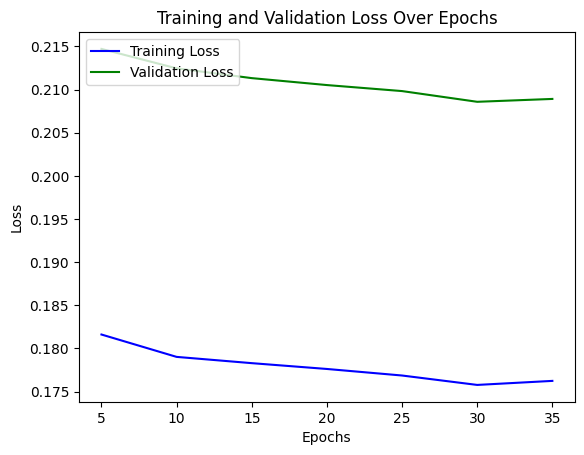

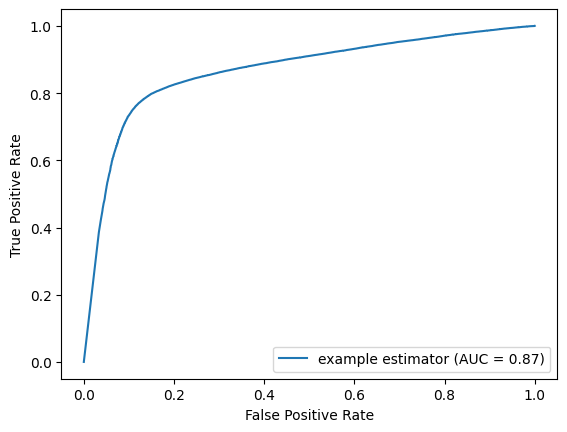

confMatrix: [[ 34936   6192]
 [ 37730 149414]]
trueSums:  [ 41128 187144]
predSums:  [ 72666 155606]


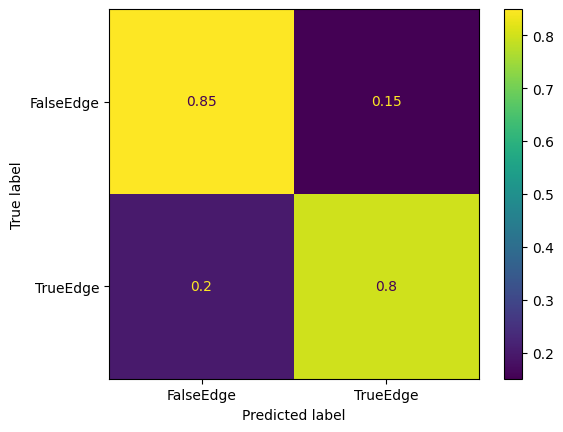

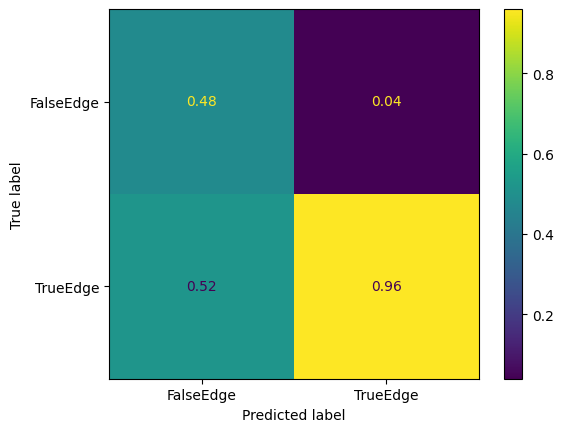

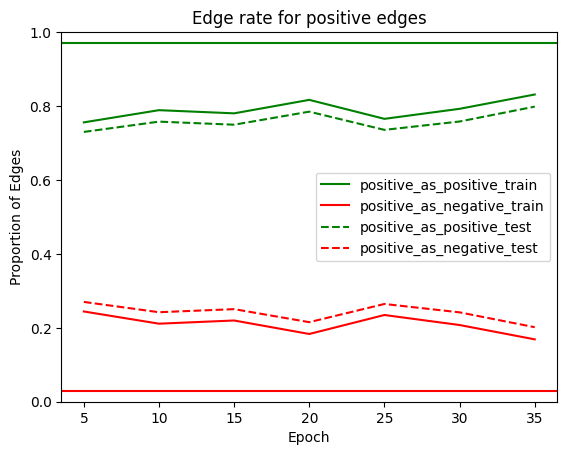

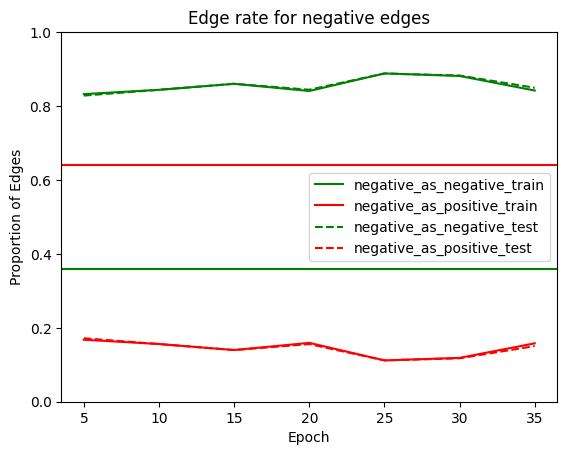

In [16]:
plot_loss(range(SAMPLE_INTERVAL, N_EPOCH, SAMPLE_INTERVAL), training_loss, test_loss)
plot_roc_curve(torch.tensor(pos_scores_test), torch.tensor(neg_scores_test))

plot_confusion_matrix(torch.tensor(pos_scores_test), torch.tensor(neg_scores_test), optimal_threshold_test)

plot_edge_rate(range(SAMPLE_INTERVAL, N_EPOCH, SAMPLE_INTERVAL), training_positive_as_positive_rate, training_positive_as_negative_rate, test_positive_as_positive_rate, test_positive_as_negative_rate, True)
plot_edge_rate(range(SAMPLE_INTERVAL, N_EPOCH, SAMPLE_INTERVAL), training_negative_as_negative_rate, training_negative_as_positive_rate, test_negative_as_negative_rate, test_negative_as_positive_rate, False)


In [17]:
######################
# Metrics for epoch 
######################  

plot_muon = False
plot_proton = False
plot_pion = False
plot_electron = False
plot_photon = True

trackShowerScore_c = []
charge_c = []
vertexX_c = []
vertexY_c = []
vertexZ_c = []
trackEndX_c = []
trackEndY_c = []
trackEndZ_c = []
showerDirX_c = []
showerDirY_c = []
showerDirZ_c = []
trackLength_c = []
displacement_c = []
dca_c = []
nHits_c = []
nuVertexEnergyAsymmetry_c = []
nuVertexEnergyWeightedMeanRadialDistance_c = []

trackShowerScore_i = []
charge_i = []
vertexX_i = []
vertexY_i = []
vertexZ_i = []
trackEndX_i = []
trackEndY_i = []
trackEndZ_i = []
showerDirX_i = []
showerDirY_i = []
showerDirZ_i = []
trackLength_i = []
displacement_i = []
dca_i = []
nHits_i = []
nuVertexEnergyAsymmetry_i = [] 
nuVertexEnergyWeightedMeanRadialDistance_i = []

with torch.no_grad():
        
    # Begin testing mode
    gnn_model.eval()
    classifier_model.eval()
        
    # Initialise metrics
    correct_muons = 0
    correct_protons = 0
    correct_pions = 0
    correct_electrons = 0
    correct_photons = 0
    n_muons = 0
    n_protons = 0
    n_pions = 0
    n_electrons = 0
    n_photons = 0
        
    count = 0
        
    # Iterate in batches over the training dataset.       
    for data, data_FC in zip(data_set_test_pos, data_set_test_FC) :
             
        count += 1
        
        #if (count < 6) :
            #continue
            
        #if (count > 6) :
            #break
            
        nu_node_indices = np.where(data.x[:,15] == 1)[0]
        muon_node_indices = np.where((data.x[:,8] == 0.5) & (data.x[:,20] > 0.2))[0]      # 8  - ivysaurus muon index        
        proton_node_indices = np.where((data.x[:,9] == 0.5) & (data.x[:,20] > 0.2))[0]    # 9  - ivysaurus proton index   
        pion_node_indices = np.where((data.x[:,10] == 0.5) & (data.x[:,20] > 0.2))[0]     # 10 - ivysaurus pion index   
        electron_node_indices = np.where((data.x[:,11] == 0.5) & (data.x[:,20] > 0.2))[0] # 11 - ivysaurus electron index   
        photon_node_indices = np.where((data.x[:,12] == 0.5) & (data.x[:,20] > 0.2))[0]   # 12 - ivysaurus photon index  
        
        #print('n_nodes:', data.x.shape[0])
        #print('data.y:', data.edge_index)
        #print('---------------------')
        #print('---------------------')
        
        muon_node_indices = muon_node_indices[np.in1d(muon_node_indices, data.edge_index[1])]
        muon_source_edge_index = np.ones(len(muon_node_indices)) * nu_node_indices[0]
        muon_edges = torch.tensor([muon_source_edge_index, muon_node_indices], dtype=torch.long)

        proton_node_indices = proton_node_indices[np.in1d(proton_node_indices, data.edge_index[1])]
        proton_source_edge_index = np.ones(len(proton_node_indices)) * nu_node_indices[0]
        proton_edges = torch.tensor([proton_source_edge_index, proton_node_indices], dtype=torch.long)        
        
        pion_node_indices = pion_node_indices[np.in1d(pion_node_indices, data.edge_index[1])]
        pion_source_edge_index = np.ones(len(pion_node_indices)) * nu_node_indices[0]
        pion_edges = torch.tensor([pion_source_edge_index, pion_node_indices], dtype=torch.long)
        
        electron_node_indices = electron_node_indices[np.in1d(electron_node_indices, data.edge_index[1])]
        electron_source_edge_index = np.ones(len(electron_node_indices)) * nu_node_indices[0]
        electron_edges = torch.tensor([electron_source_edge_index, electron_node_indices], dtype=torch.long)
        
        photon_node_indices = photon_node_indices[np.in1d(photon_node_indices, data.edge_index[1])]
        photon_source_edge_index = np.ones(len(photon_node_indices)) * nu_node_indices[0]
        photon_edges = torch.tensor([photon_source_edge_index, photon_node_indices], dtype=torch.long)
        
        pred = gnn_model(data_FC.x, data_FC.edge_index)
        
        # Muons
        if (muon_node_indices.shape[0] != 0) :
            muon_edge_pred = classifier_model(pred, muon_edges)
            #print('----------------')
            #print('muon_edges:', muon_edges)
            #print('muon_edge_pred:', muon_edge_pred)
            #print('----------------')
            correct_muons += np.count_nonzero(muon_edge_pred.detach().numpy() > optimal_threshold_test)  
            n_muons += muon_node_indices.shape[0]
            
            ############
            # For drawing
            if (plot_muon) :
                correct_muons_index = muon_edges[1][muon_edge_pred.detach().numpy() > optimal_threshold_test]
                incorrect_muons_index = muon_edges[1][muon_edge_pred.detach().numpy() < optimal_threshold_test]
            
                correct_muon_mask = np.in1d(range(data.x.shape[0]), correct_muons_index)
                incorrect_muon_mask = np.in1d(range(data.x.shape[0]), incorrect_muons_index)
                
                #print('data.x[correct_muon_mask][1]:', data.x[correct_muon_mask])
            
                if np.count_nonzero(correct_muon_mask) != 0 : trackShowerScore_c.extend(data.x[correct_muon_mask][:,0])
                if np.count_nonzero(incorrect_muon_mask) != 0 : trackShowerScore_i.extend(data.x[incorrect_muon_mask][:,0])  
                if np.count_nonzero(correct_muon_mask) != 0 : charge_c.extend(data.x[correct_muon_mask][:,1])
                if np.count_nonzero(incorrect_muon_mask) != 0 : charge_i.extend(data.x[incorrect_muon_mask][:,1])
                if np.count_nonzero(correct_muon_mask) != 0 : vertexX_c.extend(data.x[correct_muon_mask][:,2])
                if np.count_nonzero(incorrect_muon_mask) != 0 : vertexX_i.extend(data.x[incorrect_muon_mask][:,2])
                if np.count_nonzero(correct_muon_mask) != 0 : vertexY_c.extend(data.x[correct_muon_mask][:,3])
                if np.count_nonzero(incorrect_muon_mask) != 0 : vertexY_i.extend(data.x[incorrect_muon_mask][:,3])
                if np.count_nonzero(correct_muon_mask) != 0 : vertexZ_c.extend(data.x[correct_muon_mask][:,4])
                if np.count_nonzero(incorrect_muon_mask) != 0 : vertexZ_i.extend(data.x[incorrect_muon_mask][:,4])
                if np.count_nonzero(correct_muon_mask) != 0 : showerDirX_c.extend(data.x[correct_muon_mask][:,5])
                if np.count_nonzero(incorrect_muon_mask) != 0 : showerDirX_i.extend(data.x[incorrect_muon_mask][:,5])
                if np.count_nonzero(correct_muon_mask) != 0 : showerDirY_c.extend(data.x[correct_muon_mask][:,6])
                if np.count_nonzero(incorrect_muon_mask) != 0 : showerDirY_i.extend(data.x[incorrect_muon_mask][:,6])
                if np.count_nonzero(correct_muon_mask) != 0 : showerDirZ_c.extend(data.x[correct_muon_mask][:,7])
                if np.count_nonzero(incorrect_muon_mask) != 0 : showerDirZ_i.extend(data.x[incorrect_muon_mask][:,7])
                if np.count_nonzero(correct_muon_mask) != 0 : displacement_c.extend(data.x[correct_muon_mask][:,13])
                if np.count_nonzero(incorrect_muon_mask) != 0 : displacement_i.extend(data.x[incorrect_muon_mask][:,13])
                if np.count_nonzero(correct_muon_mask) != 0 : dca_c.extend(data.x[correct_muon_mask][:,14])
                if np.count_nonzero(incorrect_muon_mask) != 0 : dca_i.extend(data.x[incorrect_muon_mask][:,14])
                if np.count_nonzero(correct_muon_mask) != 0 : trackLength_c.extend(data.x[correct_muon_mask][:,16])
                if np.count_nonzero(incorrect_muon_mask) != 0 : trackLength_i.extend(data.x[incorrect_muon_mask][:,16])
                if np.count_nonzero(correct_muon_mask) != 0 : trackEndX_c.extend(data.x[correct_muon_mask][:,17])
                if np.count_nonzero(incorrect_muon_mask) != 0 : trackEndX_i.extend(data.x[incorrect_muon_mask][:,17])
                if np.count_nonzero(correct_muon_mask) != 0 : trackEndY_c.extend(data.x[correct_muon_mask][:,18])
                if np.count_nonzero(incorrect_muon_mask) != 0 : trackEndY_i.extend(data.x[incorrect_muon_mask][:,18])
                if np.count_nonzero(correct_muon_mask) != 0 : trackEndZ_c.extend(data.x[correct_muon_mask][:,19])
                if np.count_nonzero(incorrect_muon_mask) != 0 : trackEndZ_i.extend(data.x[incorrect_muon_mask][:,19])
                if np.count_nonzero(correct_muon_mask) != 0 : nHits_c.extend(data.x[correct_muon_mask][:,20])
                if np.count_nonzero(incorrect_muon_mask) != 0 : nHits_i.extend(data.x[incorrect_muon_mask][:,20])
                if np.count_nonzero(correct_muon_mask) != 0 : nuVertexEnergyAsymmetry_c.extend(data.x[correct_muon_mask][:,21])
                if np.count_nonzero(incorrect_muon_mask) != 0 : nuVertexEnergyAsymmetry_i.extend(data.x[incorrect_muon_mask][:,21])
                if np.count_nonzero(correct_muon_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_c.extend(data.x[correct_muon_mask][:,22])
                if np.count_nonzero(incorrect_muon_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_i.extend(data.x[incorrect_muon_mask][:,22])
            ############
                    
        # Protons
        if (proton_node_indices.shape[0] != 0) :
            proton_edge_pred = classifier_model(pred, proton_edges)
            #print('----------------')
            #print('proton_edges:', proton_edges)
            #print('proton_edge_pred:', proton_edge_pred)
            #print('----------------')
            correct_protons += np.count_nonzero(proton_edge_pred.detach().numpy() > optimal_threshold_test)   
            n_protons += proton_node_indices.shape[0]
            
            ############
            # For drawing
            if (plot_proton) :
                correct_protons_index = proton_edges[1][proton_edge_pred.detach().numpy() > optimal_threshold_test]
                incorrect_protons_index = proton_edges[1][proton_edge_pred.detach().numpy() < optimal_threshold_test]
            
                correct_proton_mask = np.in1d(range(data.x.shape[0]), correct_protons_index)
                incorrect_proton_mask = np.in1d(range(data.x.shape[0]), incorrect_protons_index)
            
                if np.count_nonzero(correct_proton_mask) != 0 : trackShowerScore_c.extend(data.x[correct_proton_mask][:,0])
                if np.count_nonzero(incorrect_proton_mask) != 0 : trackShowerScore_i.extend(data.x[incorrect_proton_mask][:,0])  
                if np.count_nonzero(correct_proton_mask) != 0 : charge_c.extend(data.x[correct_proton_mask][:,1])
                if np.count_nonzero(incorrect_proton_mask) != 0 : charge_i.extend(data.x[incorrect_proton_mask][:,1])
                if np.count_nonzero(correct_proton_mask) != 0 : vertexX_c.extend(data.x[correct_proton_mask][:,2])
                if np.count_nonzero(incorrect_proton_mask) != 0 : vertexX_i.extend(data.x[incorrect_proton_mask][:,2])
                if np.count_nonzero(correct_proton_mask) != 0 : vertexY_c.extend(data.x[correct_proton_mask][:,3])
                if np.count_nonzero(incorrect_proton_mask) != 0 : vertexY_i.extend(data.x[incorrect_proton_mask][:,3])
                if np.count_nonzero(correct_proton_mask) != 0 : vertexZ_c.extend(data.x[correct_proton_mask][:,4])
                if np.count_nonzero(incorrect_proton_mask) != 0 : vertexZ_i.extend(data.x[incorrect_proton_mask][:,4])
                if np.count_nonzero(correct_proton_mask) != 0 : showerDirX_c.extend(data.x[correct_proton_mask][:,5])
                if np.count_nonzero(incorrect_proton_mask) != 0 : showerDirX_i.extend(data.x[incorrect_proton_mask][:,5])
                if np.count_nonzero(correct_proton_mask) != 0 : showerDirY_c.extend(data.x[correct_proton_mask][:,6])
                if np.count_nonzero(incorrect_proton_mask) != 0 : showerDirY_i.extend(data.x[incorrect_proton_mask][:,6])
                if np.count_nonzero(correct_proton_mask) != 0 : showerDirZ_c.extend(data.x[correct_proton_mask][:,7])
                if np.count_nonzero(incorrect_proton_mask) != 0 : showerDirZ_i.extend(data.x[incorrect_proton_mask][:,7])
                if np.count_nonzero(correct_proton_mask) != 0 : displacement_c.extend(data.x[correct_proton_mask][:,13])
                if np.count_nonzero(incorrect_proton_mask) != 0 : displacement_i.extend(data.x[incorrect_proton_mask][:,13])
                if np.count_nonzero(correct_proton_mask) != 0 : dca_c.extend(data.x[correct_proton_mask][:,14])
                if np.count_nonzero(incorrect_proton_mask) != 0 : dca_i.extend(data.x[incorrect_proton_mask][:,14])
                if np.count_nonzero(correct_proton_mask) != 0 : trackLength_c.extend(data.x[correct_proton_mask][:,16])
                if np.count_nonzero(incorrect_proton_mask) != 0 : trackLength_i.extend(data.x[incorrect_proton_mask][:,16])
                if np.count_nonzero(correct_proton_mask) != 0 : trackEndX_c.extend(data.x[correct_proton_mask][:,17])
                if np.count_nonzero(incorrect_proton_mask) != 0 : trackEndX_i.extend(data.x[incorrect_proton_mask][:,17])
                if np.count_nonzero(correct_proton_mask) != 0 : trackEndY_c.extend(data.x[correct_proton_mask][:,18])
                if np.count_nonzero(incorrect_proton_mask) != 0 : trackEndY_i.extend(data.x[incorrect_proton_mask][:,18])
                if np.count_nonzero(correct_proton_mask) != 0 : trackEndZ_c.extend(data.x[correct_proton_mask][:,19])
                if np.count_nonzero(incorrect_proton_mask) != 0 : trackEndZ_i.extend(data.x[incorrect_proton_mask][:,19])
                if np.count_nonzero(correct_proton_mask) != 0 : nHits_c.extend(data.x[correct_proton_mask][:,20])
                if np.count_nonzero(incorrect_proton_mask) != 0 : nHits_i.extend(data.x[incorrect_proton_mask][:,20])
                if np.count_nonzero(correct_proton_mask) != 0 : nuVertexEnergyAsymmetry_c.extend(data.x[correct_proton_mask][:,21])
                if np.count_nonzero(incorrect_proton_mask) != 0 : nuVertexEnergyAsymmetry_i.extend(data.x[incorrect_proton_mask][:,21])
                if np.count_nonzero(correct_proton_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_c.extend(data.x[correct_proton_mask][:,22])
                if np.count_nonzero(incorrect_proton_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_i.extend(data.x[incorrect_proton_mask][:,22])
            ############
            
        # Pions
        if (pion_node_indices.shape[0] != 0) :
            pion_edge_pred = classifier_model(pred, pion_edges)
            #print('----------------')
            #print('pion_edges:', pion_edges)
            #print('pion_edge_pred:', pion_edge_pred)
            #print('----------------')
            correct_pions += np.count_nonzero(pion_edge_pred.detach().numpy() > optimal_threshold_test)   
            n_pions += pion_node_indices.shape[0]
            
            ############
            # For drawing
            if (plot_pion) :
                correct_pions_index = pion_edges[1][pion_edge_pred.detach().numpy() > optimal_threshold_test]
                incorrect_pions_index = pion_edges[1][pion_edge_pred.detach().numpy() < optimal_threshold_test]
            
                correct_pion_mask = np.in1d(range(data.x.shape[0]), correct_pions_index)
                incorrect_pion_mask = np.in1d(range(data.x.shape[0]), incorrect_pions_index)
            
                if np.count_nonzero(correct_pion_mask) != 0 : trackShowerScore_c.extend(data.x[correct_pion_mask][:,0])
                if np.count_nonzero(incorrect_pion_mask) != 0 : trackShowerScore_i.extend(data.x[incorrect_pion_mask][:,0])  
                if np.count_nonzero(correct_pion_mask) != 0 : charge_c.extend(data.x[correct_pion_mask][:,1])
                if np.count_nonzero(incorrect_pion_mask) != 0 : charge_i.extend(data.x[incorrect_pion_mask][:,1])
                if np.count_nonzero(correct_pion_mask) != 0 : vertexX_c.extend(data.x[correct_pion_mask][:,2])
                if np.count_nonzero(incorrect_pion_mask) != 0 : vertexX_i.extend(data.x[incorrect_pion_mask][:,2])
                if np.count_nonzero(correct_pion_mask) != 0 : vertexY_c.extend(data.x[correct_pion_mask][:,3])
                if np.count_nonzero(incorrect_pion_mask) != 0 : vertexY_i.extend(data.x[incorrect_pion_mask][:,3])
                if np.count_nonzero(correct_pion_mask) != 0 : vertexZ_c.extend(data.x[correct_pion_mask][:,4])
                if np.count_nonzero(incorrect_pion_mask) != 0 : vertexZ_i.extend(data.x[incorrect_pion_mask][:,4])
                if np.count_nonzero(correct_pion_mask) != 0 : showerDirX_c.extend(data.x[correct_pion_mask][:,5])
                if np.count_nonzero(incorrect_pion_mask) != 0 : showerDirX_i.extend(data.x[incorrect_pion_mask][:,5])
                if np.count_nonzero(correct_pion_mask) != 0 : showerDirY_c.extend(data.x[correct_pion_mask][:,6])
                if np.count_nonzero(incorrect_pion_mask) != 0 : showerDirY_i.extend(data.x[incorrect_pion_mask][:,6])
                if np.count_nonzero(correct_pion_mask) != 0 : showerDirZ_c.extend(data.x[correct_pion_mask][:,7])
                if np.count_nonzero(incorrect_pion_mask) != 0 : showerDirZ_i.extend(data.x[incorrect_pion_mask][:,7])
                if np.count_nonzero(correct_pion_mask) != 0 : displacement_c.extend(data.x[correct_pion_mask][:,13])
                if np.count_nonzero(incorrect_pion_mask) != 0 : displacement_i.extend(data.x[incorrect_pion_mask][:,13])
                if np.count_nonzero(correct_pion_mask) != 0 : dca_c.extend(data.x[correct_pion_mask][:,14])
                if np.count_nonzero(incorrect_pion_mask) != 0 : dca_i.extend(data.x[incorrect_pion_mask][:,14])
                if np.count_nonzero(correct_pion_mask) != 0 : trackLength_c.extend(data.x[correct_pion_mask][:,16])
                if np.count_nonzero(incorrect_pion_mask) != 0 : trackLength_i.extend(data.x[incorrect_pion_mask][:,16])
                if np.count_nonzero(correct_pion_mask) != 0 : trackEndX_c.extend(data.x[correct_pion_mask][:,17])
                if np.count_nonzero(incorrect_pion_mask) != 0 : trackEndX_i.extend(data.x[incorrect_pion_mask][:,17])
                if np.count_nonzero(correct_pion_mask) != 0 : trackEndY_c.extend(data.x[correct_pion_mask][:,18])
                if np.count_nonzero(incorrect_pion_mask) != 0 : trackEndY_i.extend(data.x[incorrect_pion_mask][:,18])
                if np.count_nonzero(correct_pion_mask) != 0 : trackEndZ_c.extend(data.x[correct_pion_mask][:,19])
                if np.count_nonzero(incorrect_pion_mask) != 0 : trackEndZ_i.extend(data.x[incorrect_pion_mask][:,19])
                if np.count_nonzero(correct_pion_mask) != 0 : nHits_c.extend(data.x[correct_pion_mask][:,20])
                if np.count_nonzero(incorrect_pion_mask) != 0 : nHits_i.extend(data.x[incorrect_pion_mask][:,20])
                if np.count_nonzero(correct_pion_mask) != 0 : nuVertexEnergyAsymmetry_c.extend(data.x[correct_pion_mask][:,21])
                if np.count_nonzero(incorrect_pion_mask) != 0 : nuVertexEnergyAsymmetry_i.extend(data.x[incorrect_pion_mask][:,21])
                if np.count_nonzero(correct_pion_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_c.extend(data.x[correct_pion_mask][:,22])
                if np.count_nonzero(incorrect_pion_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_i.extend(data.x[incorrect_pion_mask][:,22])
            ############
            
        # Electrons
        if (electron_node_indices.shape[0] != 0) :
            electron_edge_pred = classifier_model(pred, electron_edges)
            #print('----------------')
            #print('electron_edges:', electron_edges)
            #print('electron_edge_pred:', electron_edge_pred)
            #print('----------------')
            correct_electrons += np.count_nonzero(electron_edge_pred.detach().numpy() > optimal_threshold_test)   
            n_electrons += electron_node_indices.shape[0]
            
            ############
            # For drawing
            if (plot_electron) :
                correct_electrons_index = electron_edges[1][electron_edge_pred.detach().numpy() > optimal_threshold_test]
                incorrect_electrons_index = electron_edges[1][electron_edge_pred.detach().numpy() < optimal_threshold_test]
            
                correct_electron_mask = np.in1d(range(data.x.shape[0]), correct_electrons_index)
                incorrect_electron_mask = np.in1d(range(data.x.shape[0]), incorrect_electrons_index)
            
                if np.count_nonzero(correct_electron_mask) != 0 : trackShowerScore_c.extend(data.x[correct_electron_mask][:,0])
                if np.count_nonzero(incorrect_electron_mask) != 0 : trackShowerScore_i.extend(data.x[incorrect_electron_mask][:,0])  
                if np.count_nonzero(correct_electron_mask) != 0 : charge_c.extend(data.x[correct_electron_mask][:,1])
                if np.count_nonzero(incorrect_electron_mask) != 0 : charge_i.extend(data.x[incorrect_electron_mask][:,1])
                if np.count_nonzero(correct_electron_mask) != 0 : vertexX_c.extend(data.x[correct_electron_mask][:,2])
                if np.count_nonzero(incorrect_electron_mask) != 0 : vertexX_i.extend(data.x[incorrect_electron_mask][:,2])
                if np.count_nonzero(correct_electron_mask) != 0 : vertexY_c.extend(data.x[correct_electron_mask][:,3])
                if np.count_nonzero(incorrect_electron_mask) != 0 : vertexY_i.extend(data.x[incorrect_electron_mask][:,3])
                if np.count_nonzero(correct_electron_mask) != 0 : vertexZ_c.extend(data.x[correct_electron_mask][:,4])
                if np.count_nonzero(incorrect_electron_mask) != 0 : vertexZ_i.extend(data.x[incorrect_electron_mask][:,4])
                if np.count_nonzero(correct_electron_mask) != 0 : showerDirX_c.extend(data.x[correct_electron_mask][:,5])
                if np.count_nonzero(incorrect_electron_mask) != 0 : showerDirX_i.extend(data.x[incorrect_electron_mask][:,5])
                if np.count_nonzero(correct_electron_mask) != 0 : showerDirY_c.extend(data.x[correct_electron_mask][:,6])
                if np.count_nonzero(incorrect_electron_mask) != 0 : showerDirY_i.extend(data.x[incorrect_electron_mask][:,6])
                if np.count_nonzero(correct_electron_mask) != 0 : showerDirZ_c.extend(data.x[correct_electron_mask][:,7])
                if np.count_nonzero(incorrect_electron_mask) != 0 : showerDirZ_i.extend(data.x[incorrect_electron_mask][:,7])
                if np.count_nonzero(correct_electron_mask) != 0 : displacement_c.extend(data.x[correct_electron_mask][:,13])
                if np.count_nonzero(incorrect_electron_mask) != 0 : displacement_i.extend(data.x[incorrect_electron_mask][:,13])
                if np.count_nonzero(correct_electron_mask) != 0 : dca_c.extend(data.x[correct_electron_mask][:,14])
                if np.count_nonzero(incorrect_electron_mask) != 0 : dca_i.extend(data.x[incorrect_electron_mask][:,14])
                if np.count_nonzero(correct_electron_mask) != 0 : trackLength_c.extend(data.x[correct_electron_mask][:,16])
                if np.count_nonzero(incorrect_electron_mask) != 0 : trackLength_i.extend(data.x[incorrect_electron_mask][:,16])
                if np.count_nonzero(correct_electron_mask) != 0 : trackEndX_c.extend(data.x[correct_electron_mask][:,17])
                if np.count_nonzero(incorrect_electron_mask) != 0 : trackEndX_i.extend(data.x[incorrect_electron_mask][:,17])
                if np.count_nonzero(correct_electron_mask) != 0 : trackEndY_c.extend(data.x[correct_electron_mask][:,18])
                if np.count_nonzero(incorrect_electron_mask) != 0 : trackEndY_i.extend(data.x[incorrect_electron_mask][:,18])
                if np.count_nonzero(correct_electron_mask) != 0 : trackEndZ_c.extend(data.x[correct_electron_mask][:,19])
                if np.count_nonzero(incorrect_electron_mask) != 0 : trackEndZ_i.extend(data.x[incorrect_electron_mask][:,19])     
                if np.count_nonzero(correct_electron_mask) != 0 : nHits_c.extend(data.x[correct_electron_mask][:,20])
                if np.count_nonzero(incorrect_electron_mask) != 0 : nHits_i.extend(data.x[incorrect_electron_mask][:,20])
                if np.count_nonzero(correct_electron_mask) != 0 : nuVertexEnergyAsymmetry_c.extend(data.x[correct_electron_mask][:,21])
                if np.count_nonzero(incorrect_electron_mask) != 0 : nuVertexEnergyAsymmetry_i.extend(data.x[incorrect_electron_mask][:,21])
                if np.count_nonzero(correct_electron_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_c.extend(data.x[correct_electron_mask][:,22])
                if np.count_nonzero(incorrect_electron_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_i.extend(data.x[incorrect_electron_mask][:,22])
            ############
            
        # Photons
        if (photon_node_indices.shape[0] != 0) :
            photon_edge_pred = classifier_model(pred, photon_edges)
            #print('----------------')
            #print('photon_edges:', photon_edges)
            #print('photon_edge_pred:', photon_edge_pred)
            #print('----------------')
            correct_photons += np.count_nonzero(photon_edge_pred.detach().numpy() > optimal_threshold_test)   
            n_photons += photon_node_indices.shape[0]
            
            ############
            # For drawing
            if (plot_photon) :
                correct_photons_index = photon_edges[1][photon_edge_pred.detach().numpy() > optimal_threshold_test]
                incorrect_photons_index = photon_edges[1][photon_edge_pred.detach().numpy() < optimal_threshold_test]
            
                correct_photon_mask = np.in1d(range(data.x.shape[0]), correct_photons_index)
                incorrect_photon_mask = np.in1d(range(data.x.shape[0]), incorrect_photons_index)
            
                if np.count_nonzero(correct_photon_mask) != 0 : trackShowerScore_c.extend(data.x[correct_photon_mask][:,0])
                if np.count_nonzero(incorrect_photon_mask) != 0 : trackShowerScore_i.extend(data.x[incorrect_photon_mask][:,0])  
                if np.count_nonzero(correct_photon_mask) != 0 : charge_c.extend(data.x[correct_photon_mask][:,1])
                if np.count_nonzero(incorrect_photon_mask) != 0 : charge_i.extend(data.x[incorrect_photon_mask][:,1])
                if np.count_nonzero(correct_photon_mask) != 0 : vertexX_c.extend(data.x[correct_photon_mask][:,2])
                if np.count_nonzero(incorrect_photon_mask) != 0 : vertexX_i.extend(data.x[incorrect_photon_mask][:,2])
                if np.count_nonzero(correct_photon_mask) != 0 : vertexY_c.extend(data.x[correct_photon_mask][:,3])
                if np.count_nonzero(incorrect_photon_mask) != 0 : vertexY_i.extend(data.x[incorrect_photon_mask][:,3])
                if np.count_nonzero(correct_photon_mask) != 0 : vertexZ_c.extend(data.x[correct_photon_mask][:,4])
                if np.count_nonzero(incorrect_photon_mask) != 0 : vertexZ_i.extend(data.x[incorrect_photon_mask][:,4])
                if np.count_nonzero(correct_photon_mask) != 0 : showerDirX_c.extend(data.x[correct_photon_mask][:,5])
                if np.count_nonzero(incorrect_photon_mask) != 0 : showerDirX_i.extend(data.x[incorrect_photon_mask][:,5])
                if np.count_nonzero(correct_photon_mask) != 0 : showerDirY_c.extend(data.x[correct_photon_mask][:,6])
                if np.count_nonzero(incorrect_photon_mask) != 0 : showerDirY_i.extend(data.x[incorrect_photon_mask][:,6])
                if np.count_nonzero(correct_photon_mask) != 0 : showerDirZ_c.extend(data.x[correct_photon_mask][:,7])
                if np.count_nonzero(incorrect_photon_mask) != 0 : showerDirZ_i.extend(data.x[incorrect_photon_mask][:,7])
                if np.count_nonzero(correct_photon_mask) != 0 : displacement_c.extend(data.x[correct_photon_mask][:,13])
                if np.count_nonzero(incorrect_photon_mask) != 0 : displacement_i.extend(data.x[incorrect_photon_mask][:,13])
                if np.count_nonzero(correct_photon_mask) != 0 : dca_c.extend(data.x[correct_photon_mask][:,14])
                if np.count_nonzero(incorrect_photon_mask) != 0 : dca_i.extend(data.x[incorrect_photon_mask][:,14])
                if np.count_nonzero(correct_photon_mask) != 0 : trackLength_c.extend(data.x[correct_photon_mask][:,16])
                if np.count_nonzero(incorrect_photon_mask) != 0 : trackLength_i.extend(data.x[incorrect_photon_mask][:,16])
                if np.count_nonzero(correct_photon_mask) != 0 : trackEndX_c.extend(data.x[correct_photon_mask][:,17])
                if np.count_nonzero(incorrect_photon_mask) != 0 : trackEndX_i.extend(data.x[incorrect_photon_mask][:,17])
                if np.count_nonzero(correct_photon_mask) != 0 : trackEndY_c.extend(data.x[correct_photon_mask][:,18])
                if np.count_nonzero(incorrect_photon_mask) != 0 : trackEndY_i.extend(data.x[incorrect_photon_mask][:,18])
                if np.count_nonzero(correct_photon_mask) != 0 : trackEndZ_c.extend(data.x[correct_photon_mask][:,19])
                if np.count_nonzero(incorrect_photon_mask) != 0 : trackEndZ_i.extend(data.x[incorrect_photon_mask][:,19])
                                    
                if np.count_nonzero(correct_photon_mask) != 0 : nHits_c.extend(data.x[correct_photon_mask][:,20])
                if np.count_nonzero(incorrect_photon_mask) != 0 : nHits_i.extend(data.x[incorrect_photon_mask][:,20])
                if np.count_nonzero(correct_photon_mask) != 0 : nuVertexEnergyAsymmetry_c.extend(data.x[correct_photon_mask][:,21])
                if np.count_nonzero(incorrect_photon_mask) != 0 : nuVertexEnergyAsymmetry_i.extend(data.x[incorrect_photon_mask][:,21])
                if np.count_nonzero(correct_photon_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_c.extend(data.x[correct_photon_mask][:,22])
                if np.count_nonzero(incorrect_photon_mask) != 0 : nuVertexEnergyWeightedMeanRadialDistance_i.extend(data.x[incorrect_photon_mask][:,22])
            ############
            
        
        #print('n_muons:', n_muons)
        #print('n_protons:', n_protons)
        #print('n_pions:', n_pions)
        #print('n_electrons:', n_electrons)
        #print('n_photons:', n_photons)
     
    print('optimal_threshold_test:', optimal_threshold_test)
    print('correct_muons:', str(round(0 if n_muons == 0 else float(correct_muons) / float(n_muons) * 100.0, 2)) + '%')
    print('correct_protons:', str(round(0 if n_protons == 0 else float(correct_protons) / float(n_protons) * 100.0, 2)) + '%')
    print('correct_pions:', str(round(0 if n_pions == 0 else float(correct_pions) / float(n_pions) * 100.0, 2)) + '%')
    print('correct_electrons:', str(round(0 if n_electrons == 0 else float(correct_electrons) / float(n_electrons) * 100.0, 2)) + '%')
    print('correct_photons:', str(round(0 if n_photons == 0 else float(correct_photons) / float(n_photons) * 100.0, 2)) + '%')
    
    nCorrectEdges = correct_muons + correct_protons + correct_pions + correct_electrons + correct_photons
    nEdges = n_muons + n_protons + n_pions + n_electrons + n_photons
    print('total correct:', str(nCorrectEdges))
    print('total positive edges:', str(nEdges))
    print('total correct fraction:', str(round(0 if nEdges == 0 else float(nCorrectEdges) / float(nEdges) * 100.0, 2)) + '%')

NameError: name 'classifier_model' is not defined

In [ ]:
weights_c = np.ones_like(trackShowerScore_c)/len(trackShowerScore_c)
weights_i = np.ones_like(trackShowerScore_i)/len(trackShowerScore_i)

n_bins = 100

# TrackScore
plt.hist(trackShowerScore_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(trackShowerScore_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1],color='red', weights=weights_i)
plt.title('TrackScore')
plt.xlabel('TrackScore')
plt.grid(True)
plt.show()

# Charge
plt.hist(charge_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(charge_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('charge')
plt.xlabel('charge')
plt.grid(True)
plt.show()
    
# vertexX
plt.hist(vertexX_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(vertexX_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('vertex X')
plt.xlabel('vertex X')
plt.grid(True)
plt.show()

# vertexY
plt.hist(vertexY_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(vertexY_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('vertex Y')
plt.xlabel('vertex Y')
plt.grid(True)
plt.show()

# vertexZ
plt.hist(vertexZ_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(vertexZ_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('vertex Z')
plt.xlabel('vertex Z')
plt.grid(True)
plt.show()

# trackEndX
plt.hist(trackEndX_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(trackEndX_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('trackEnd X')
plt.xlabel('trackEnd X')
plt.grid(True)
plt.show()

# trackEndY
plt.hist(trackEndY_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(trackEndY_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1],color='red', weights=weights_i)
plt.title('trackEnd Y')
plt.xlabel('trackEnd Y')
plt.grid(True)
plt.show()

# trackEndZ
plt.hist(trackEndZ_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(trackEndZ_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)
plt.title('trackEnd Z')
plt.xlabel('trackEnd Z')
plt.grid(True)
plt.show()

# showerDirX
plt.hist(showerDirX_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(showerDirX_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)    
plt.title('showerDir X')
plt.xlabel('showerDir X')
plt.grid(True)
plt.show()

# showerDirY
plt.hist(showerDirY_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(showerDirY_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)    
plt.title('showerDir Y')
plt.xlabel('showerDir Y')
plt.grid(True)
plt.show()

# showerDirZ
plt.hist(showerDirZ_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)    
plt.hist(showerDirZ_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)    
plt.title('showerDir Z')
plt.xlabel('showerDir Z')
plt.grid(True)
plt.show()

# trackLength
plt.hist(trackLength_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(trackLength_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('trackLength')
plt.xlabel('trackLength')
plt.grid(True)
plt.show()

# displacement
plt.hist(displacement_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(displacement_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('displacement')
plt.xlabel('displacement')
plt.grid(True)
plt.show()

# dca
plt.hist(dca_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(dca_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('dca')
plt.xlabel('dca')
plt.grid(True)
plt.show()

# nHits
print('nHits_c', len(nHits_c))
print('nHits_i', len(nHits_i))
plt.hist(nHits_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(nHits_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('nHits')
plt.xlabel('nHits')
plt.grid(True)
plt.show()

# nuVertexEnergyAsymmetry
plt.hist(nuVertexEnergyAsymmetry_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(nuVertexEnergyAsymmetry_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('nuVertexEnergyAsymmetry')
plt.xlabel('nuVertexEnergyAsymmetry')
plt.grid(True)
plt.show()

# nuVertexEnergyWeightedMeanRadialDistance
plt.hist(nuVertexEnergyWeightedMeanRadialDistance_c, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='green', weights=weights_c)
plt.hist(nuVertexEnergyWeightedMeanRadialDistance_i, bins=n_bins, alpha=0.5, range=[-1.1, 1.1], color='red', weights=weights_i)   
plt.title('nuVertexEnergyWeightedMeanRadialDistance')
plt.xlabel('nuVertexEnergyWeightedMeanRadialDistance')
plt.grid(True)
plt.show()